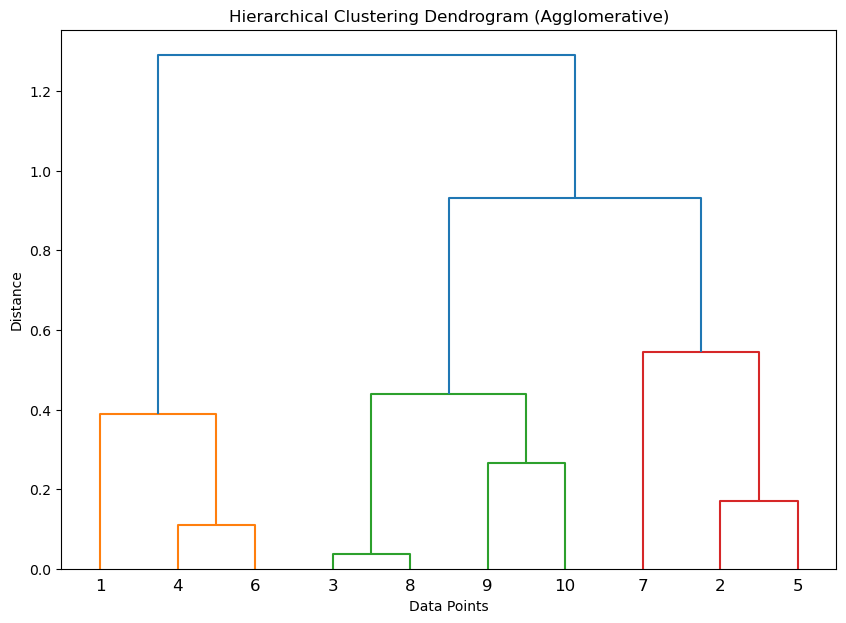

In [1]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Sample Data (Replace with your data if needed)
np.random.seed(42)
data = np.random.rand(10, 2)  # 10 data points in 2 dimensions

# Perform Agglomerative Clustering
Z = linkage(data, method='ward')

# Plot Dendrogram for Agglomerative Clustering
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=np.arange(1, len(data) + 1))
plt.title('Hierarchical Clustering Dendrogram (Agglomerative)')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


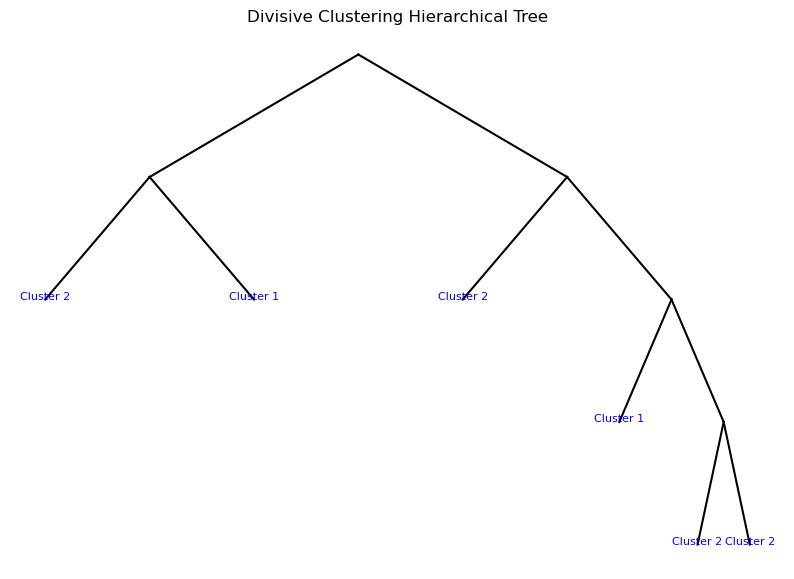

In [20]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Adjust to 1 or another small number

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Sample Data
np.random.seed(42)
data = np.random.rand(10, 2)  # 10 data points in 2 dimensions

# Divisive Clustering Function to Create Hierarchical Structure for Plotting
def divisive_clustering_plot(data, x=0, y=10, level=0, ax=None, threshold=2):
    if len(data) <= threshold:
        # Plot leaf node
        ax.text(x, y, f'Cluster {len(data)}', ha='center', fontsize=8, color='blue')
        return x, x  # Return x-coordinates span of the cluster

    # Split data into two clusters using KMeans
    kmeans = KMeans(n_clusters=2, random_state=42).fit(data)
    labels = kmeans.labels_

    # Divide data into two clusters
    cluster1 = data[labels == 0]
    cluster2 = data[labels == 1]

    # Calculate next positions for left and right child nodes
    left_x, right_x = x - 2**(3-level), x + 2**(3-level)

    # Plot the central node line
    ax.plot([x, left_x], [y, y-2], 'k-')
    ax.plot([x, right_x], [y, y-2], 'k-')

    # Recursive plot for left and right clusters
    left_span = divisive_clustering_plot(cluster1, left_x, y-2, level+1, ax, threshold)
    right_span = divisive_clustering_plot(cluster2, right_x, y-2, level+1, ax, threshold)

    return min(left_span[0], right_span[0]), max(left_span[1], right_span[1])

# Plot setup
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Divisive Clustering Hierarchical Tree')
ax.axis('off')

# Apply Divisive Clustering and plot
divisive_clustering_plot(data, ax=ax)

plt.show()


### Clustering (Iris)

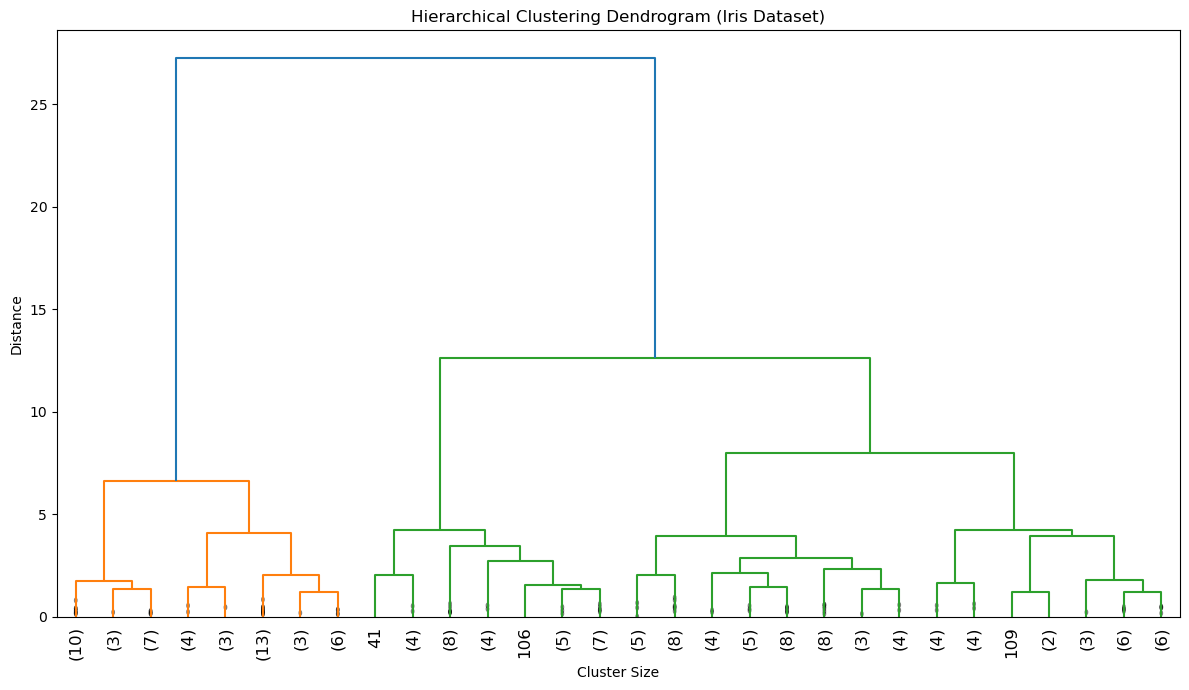

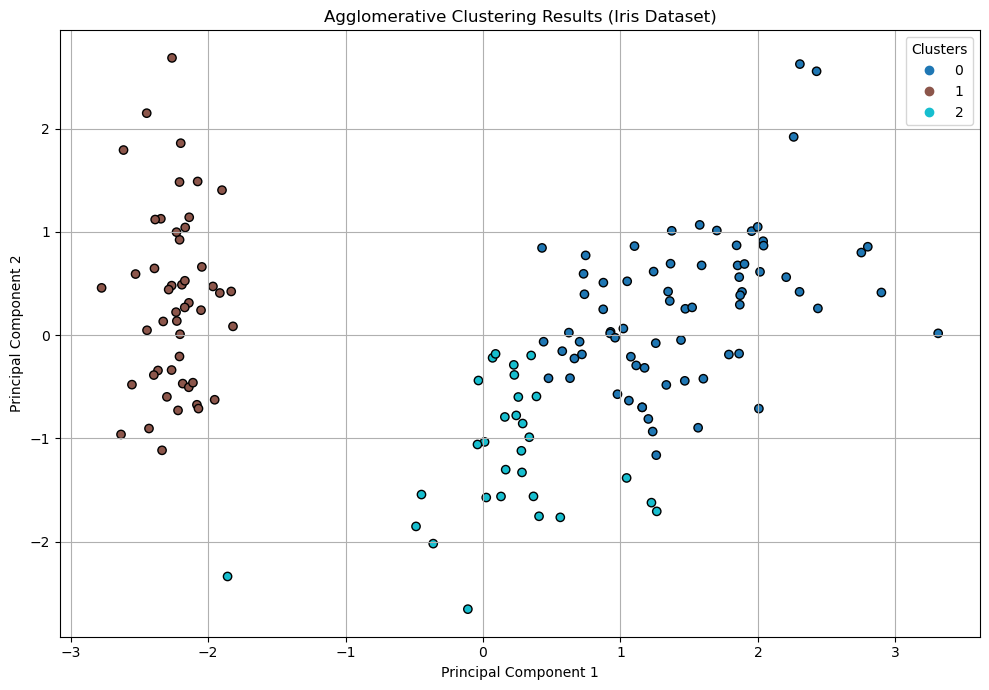

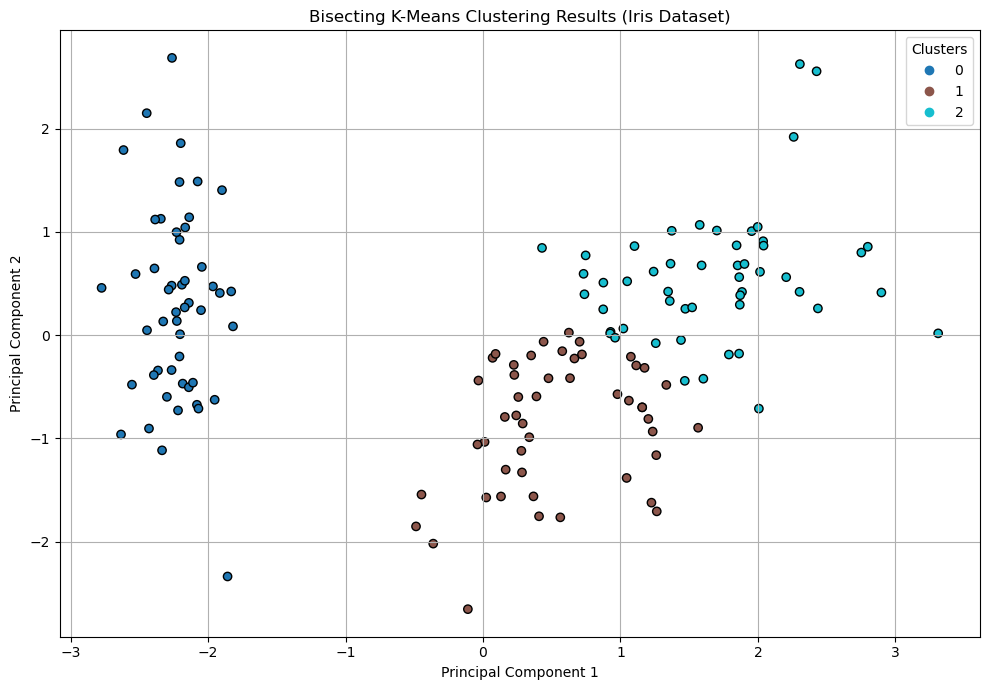

In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from collections import deque
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -----------------------------
# Load and Prepare the Data
# -----------------------------

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target  # True labels (not used in clustering)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# -----------------------------
# Agglomerative Clustering
# -----------------------------

# Perform hierarchical clustering using linkage method for dendrogram
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=30,  # show only the last 30 merged clusters
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Iris Dataset)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Determine the number of clusters
n_clusters = 3  # There are 3 species in the Iris dataset

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(X_scaled)

# Plot the Agglomerative Clustering results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='tab10', edgecolor='k')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Agglomerative Clustering Results (Iris Dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Bisecting K-Means Clustering
# -----------------------------

class BisectingKMeans:
    """
    Implements Bisecting K-Means Clustering.
    
    Parameters:
    -----------
    n_clusters : int
        The number of clusters to form.
    max_iter : int, default=100
        Maximum number of iterations for a single K-Means run.
    random_state : int or None, default=None
        Determines random number generation for centroid initialization.
    """
    def __init__(self, n_clusters=3, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.labels_ = None

    def fit(self, X):
        """
        Computes Bisecting K-Means clustering.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The data to cluster.
        """
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        cluster_id_counter = 0  # Start cluster IDs from 0
        clusters = {cluster_id_counter: np.arange(n_samples)}
        cluster_id_counter += 1

        while len(clusters) < self.n_clusters:
            # Select the cluster with the largest number of points to split
            largest_cluster_id = max(clusters, key=lambda k: len(clusters[k]))
            data_indices = clusters[largest_cluster_id]
            data = X[data_indices]

            if len(data_indices) <= 1:
                # Cannot split clusters with one or zero data points
                print(f"Cluster {largest_cluster_id} has too few points to split.")
                break

            # Perform K-Means with k=2 on the current cluster
            kmeans = KMeans(n_clusters=2, max_iter=self.max_iter, random_state=self.random_state)
            kmeans.fit(data)
            labels_kmeans = kmeans.labels_

            # Assign new cluster IDs to the two clusters
            left_child_id = cluster_id_counter
            cluster_id_counter += 1
            right_child_id = cluster_id_counter
            cluster_id_counter += 1

            # Map the data indices to the new clusters
            clusters[left_child_id] = data_indices[labels_kmeans == 0]
            clusters[right_child_id] = data_indices[labels_kmeans == 1]

            # Remove the parent cluster
            del clusters[largest_cluster_id]

        # Assign labels
        # Map the cluster IDs to a range from 0 to n_clusters - 1
        final_cluster_ids = list(clusters.keys())
        cluster_id_map = {cluster_id: idx for idx, cluster_id in enumerate(final_cluster_ids)}
        for cluster_id, data_indices in clusters.items():
            self.labels_[data_indices] = cluster_id_map[cluster_id]

    def plot_clusters(self, X_pca):
        """
        Plots the clustering results.
        
        Parameters:
        -----------
        X_pca : array-like of shape (n_samples, 2)
            The data projected onto two principal components.
        """
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.labels_, cmap='tab10', edgecolor='k')
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.title('Bisecting K-Means Clustering Results (Iris Dataset)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Instantiate and fit the Bisecting K-Means model
bisect_kmeans = BisectingKMeans(n_clusters=3, random_state=42)
bisect_kmeans.fit(X_scaled)  # Fit on the scaled data

# Plot the Bisecting K-Means Clustering results
bisect_kmeans.plot_clusters(X_pca)


In [8]:
pip install pydot

  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
Using cached pydot-3.0.2-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


### Breast Cancer dataset

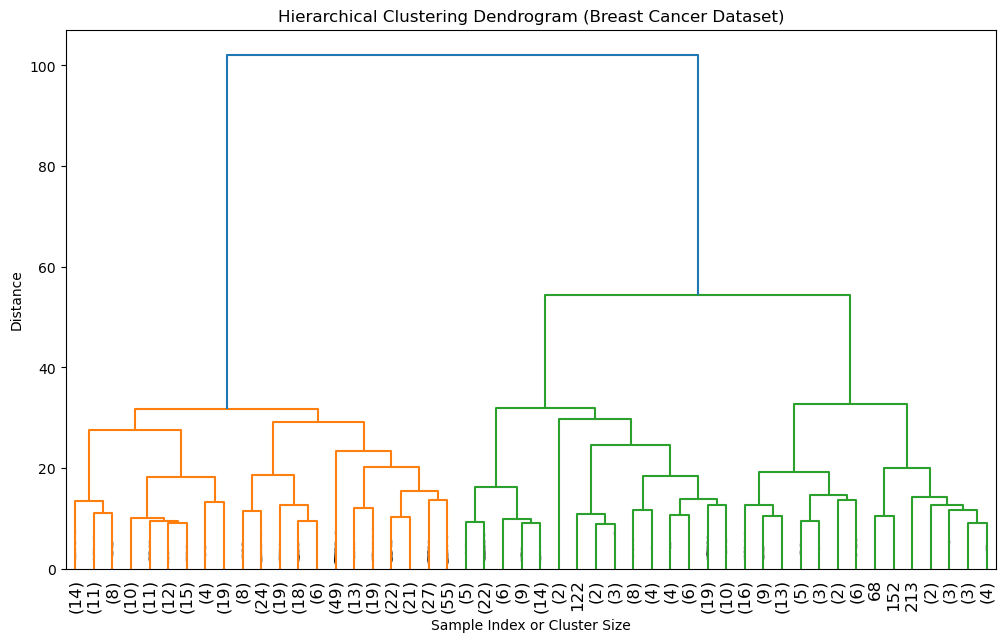

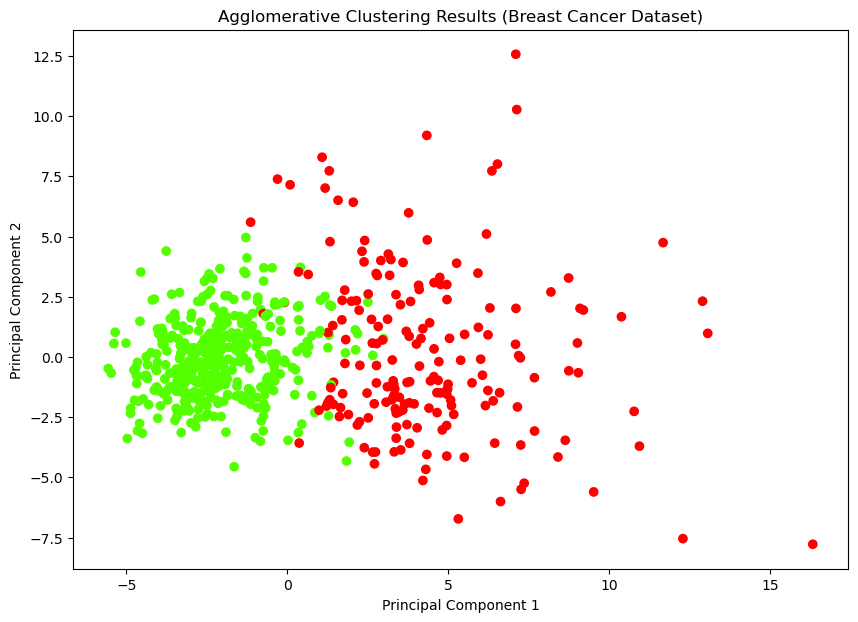

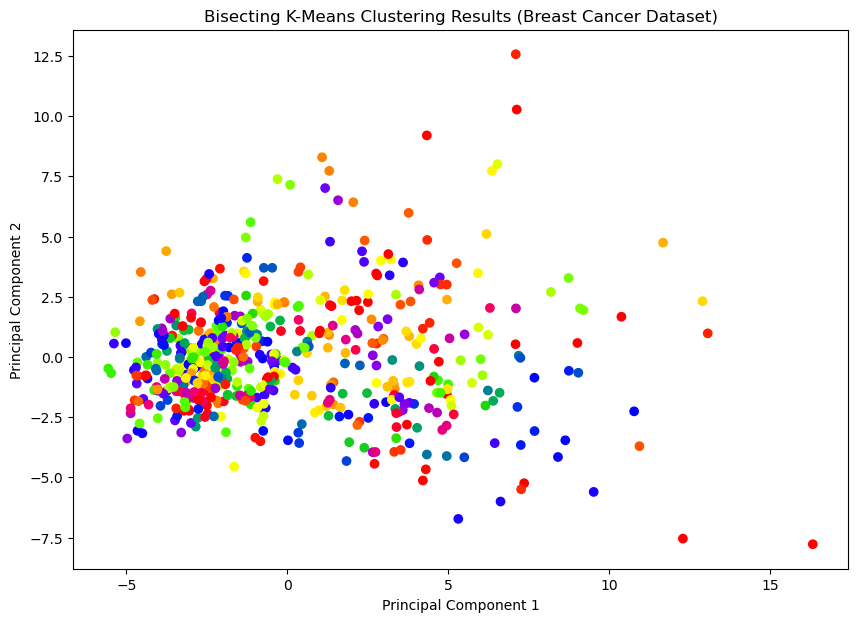

Graphviz layout not found, using spring layout instead.


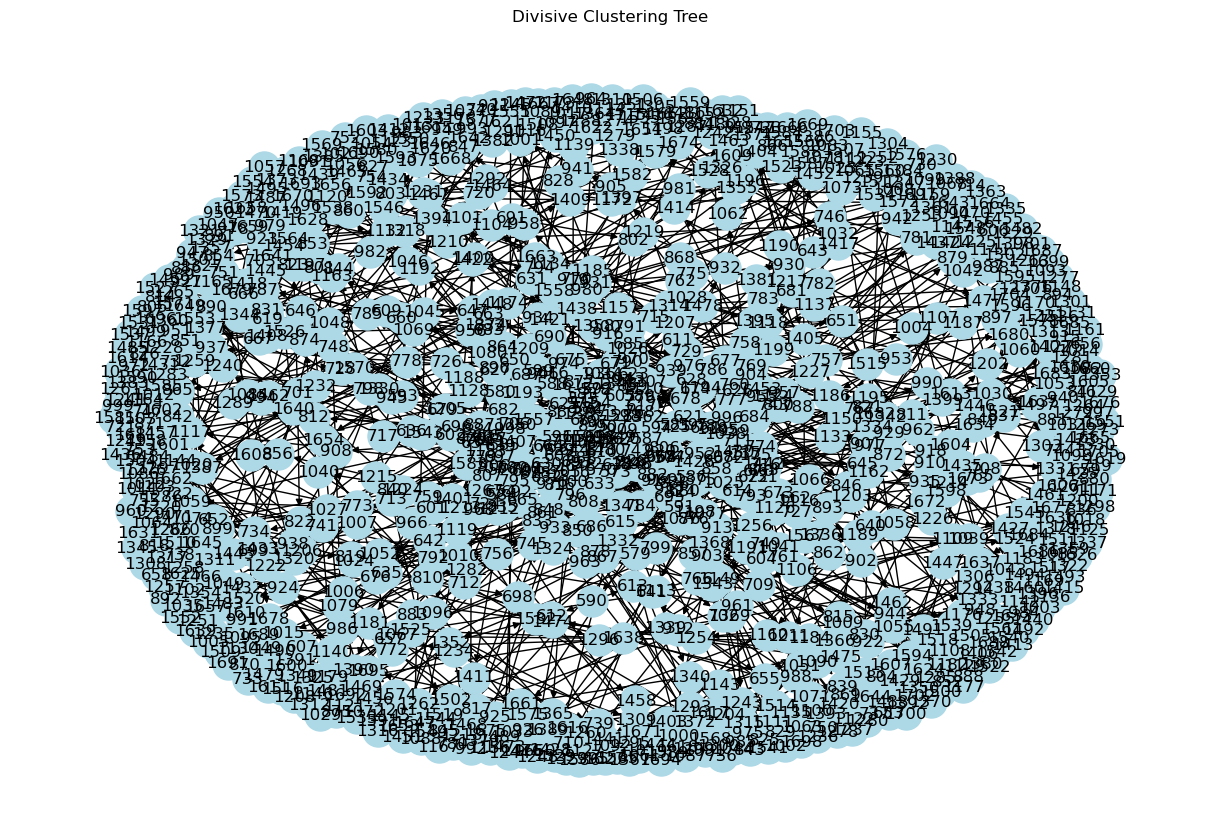

In [16]:
# Import necessary libraries
import os  # Added to set environment variables
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx  # For tree plotting
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from threadpoolctl import threadpool_limits  # Added to limit threads

# Set the number of threads to 1 to avoid warnings
os.environ["OMP_NUM_THREADS"] = "1"

# Alternatively, you can limit threads using threadpoolctl in specific parts of your code.

# Load the Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target  # True labels (not used in clustering)
feature_names = data.feature_names

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# -----------------------------
# Agglomerative Clustering
# -----------------------------

# Perform hierarchical clustering using linkage method for dendrogram
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=50,  # show only the last 50 merged clusters
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Breast Cancer Dataset)')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

# Determine the number of clusters
n_clusters = 2

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='prism')
plt.title('Agglomerative Clustering Results (Breast Cancer Dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# -----------------------------
# Bisecting K-Means Clustering
# -----------------------------

# Define the Bisecting K-Means class with thread limiting
class BisectingKMeans:
    def __init__(self, n_clusters=2, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.labels_ = None
        self.tree_edges = []  # To store tree structure

    def fit(self, X):
        from collections import deque

        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        cluster_id_counter = n_samples  # Start cluster IDs from n_samples
        clusters = {cluster_id_counter: np.arange(n_samples)}
        cluster_queue = deque()
        cluster_queue.append(cluster_id_counter)
        cluster_id_counter += 1

        # Tree structure for plotting
        self.tree_edges = []

        while len(clusters) - n_samples + 1 < self.n_clusters:
            if not cluster_queue:
                break  # No more clusters to split

            current_cluster_id = cluster_queue.popleft()
            current_data_indices = clusters[current_cluster_id]
            current_data = X[current_data_indices]

            if len(current_data_indices) <= 1:
                continue  # Cannot split clusters with one or zero data points

            # Limit threads during KMeans fitting to avoid warnings
            with threadpool_limits(limits=1):
                # Perform k-means with k=2 on the current cluster
                kmeans = KMeans(n_clusters=2, max_iter=self.max_iter, random_state=self.random_state)
                kmeans.fit(current_data)

            labels_kmeans = kmeans.labels_

            # Assign new cluster IDs to the two clusters
            left_child_id = cluster_id_counter
            cluster_id_counter += 1
            right_child_id = cluster_id_counter
            cluster_id_counter += 1

            # Map the data indices to the new clusters
            clusters[left_child_id] = current_data_indices[labels_kmeans == 0]
            clusters[right_child_id] = current_data_indices[labels_kmeans == 1]

            # Record the split in the tree edges
            self.tree_edges.append((current_cluster_id, left_child_id))
            self.tree_edges.append((current_cluster_id, right_child_id))

            # Remove the parent cluster
            del clusters[current_cluster_id]

            # Add the new clusters to the queue
            cluster_queue.append(left_child_id)
            cluster_queue.append(right_child_id)

        # Assign labels
        # Map the cluster IDs to a range from 0 to n_clusters - 1
        final_clusters = list(clusters.keys())
        cluster_id_map = {cluster_id: idx for idx, cluster_id in enumerate(final_clusters)}
        for cluster_id, data_indices in clusters.items():
            self.labels_[data_indices] = cluster_id_map[cluster_id]

    def plot_clusters(self, X):
        plt.figure(figsize=(10, 7))
        plt.scatter(X[:, 0], X[:, 1], c=self.labels_, cmap='prism')
        plt.title('Bisecting K-Means Clustering Results (Breast Cancer Dataset)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

    def plot_tree(self):
        G = nx.DiGraph()
        G.add_edges_from(self.tree_edges)

        try:
            pos = nx.nx_pydot.graphviz_layout(G, prog='dot')  # Requires pydot and Graphviz
        except (ImportError, FileNotFoundError):
            print("Graphviz layout not found, using spring layout instead.")
            pos = nx.spring_layout(G)

        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, arrows=True, node_size=500, node_color='lightblue')
        plt.title('Divisive Clustering Tree')
        plt.show()

# Instantiate and fit the Bisecting K-Means model
bisect_kmeans = BisectingKMeans(n_clusters=2, random_state=42)
bisect_kmeans.fit(X_pca)  # Using PCA-reduced data

# Plot the clustering results
bisect_kmeans.plot_clusters(X_pca)

# Plot the hierarchical tree
bisect_kmeans.plot_tree()


### Digits dataset

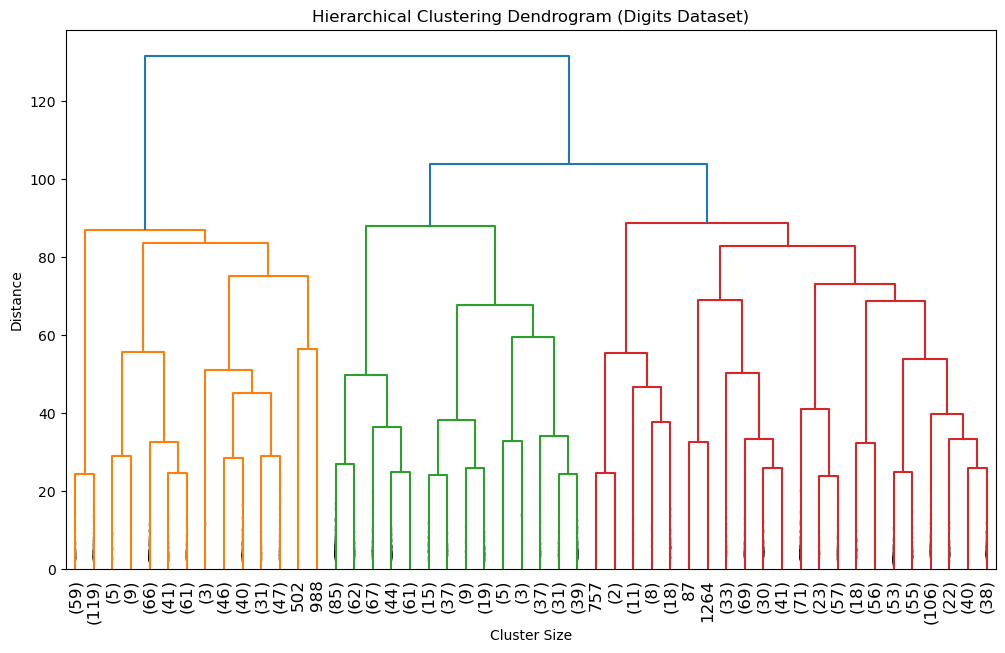

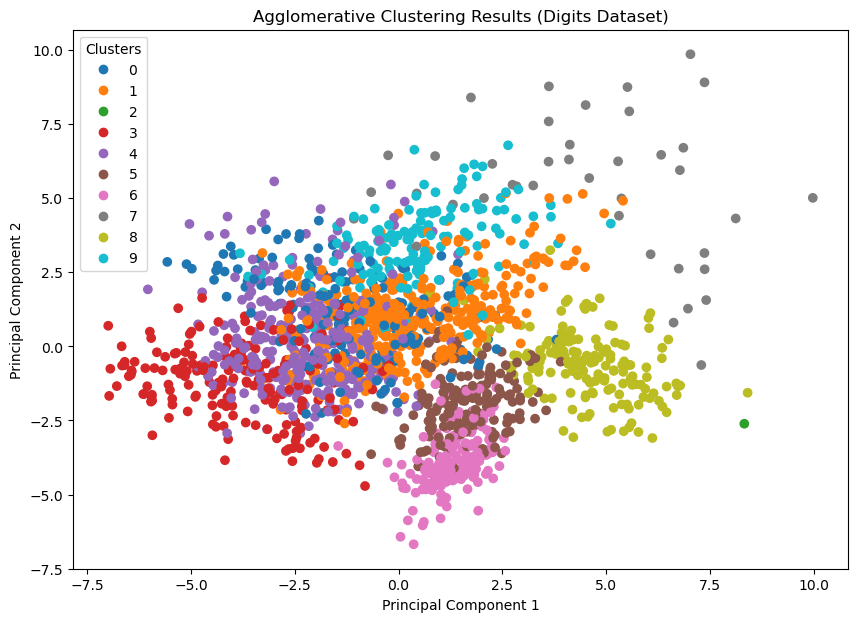

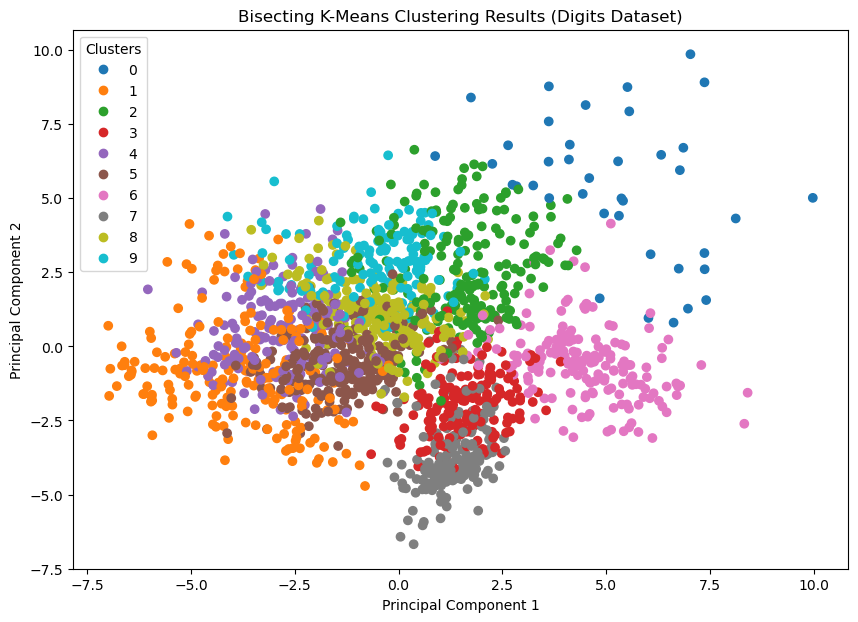

In [27]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from collections import deque
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -----------------------------
# Load and Prepare the Data
# -----------------------------

# Load the Digits dataset
digits = load_digits()
X = digits.data
y = digits.target  # True labels (not used in clustering)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# -----------------------------
# Agglomerative Clustering
# -----------------------------

# Perform hierarchical clustering using linkage method for dendrogram
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=50,  # show only the last 50 merged clusters
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Digits Dataset)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

# Determine the number of clusters
n_clusters = 10  # There are 10 digits (0-9)

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Agglomerative Clustering Results (Digits Dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# -----------------------------
# Bisecting K-Means Clustering
# -----------------------------

# Define the Bisecting K-Means class
class BisectingKMeans:
    def __init__(self, n_clusters=10, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        cluster_id_counter = 0  # Start cluster IDs from 0
        clusters = {cluster_id_counter: np.arange(n_samples)}
        cluster_id_counter += 1

        while len(clusters) < self.n_clusters:
            # Select the cluster with the largest number of points to split
            largest_cluster_id = max(clusters, key=lambda k: len(clusters[k]))
            data_indices = clusters[largest_cluster_id]
            data = X[data_indices]

            if len(data_indices) <= 1:
                # Cannot split clusters with one or zero data points
                break

            # Perform k-means with k=2 on the current cluster
            kmeans = KMeans(n_clusters=2, max_iter=self.max_iter, random_state=self.random_state)
            kmeans.fit(data)
            labels_kmeans = kmeans.labels_

            # Assign new cluster IDs to the two clusters
            left_child_id = cluster_id_counter
            cluster_id_counter += 1
            right_child_id = cluster_id_counter
            cluster_id_counter += 1

            # Map the data indices to the new clusters
            clusters[left_child_id] = data_indices[labels_kmeans == 0]
            clusters[right_child_id] = data_indices[labels_kmeans == 1]

            # Remove the parent cluster
            del clusters[largest_cluster_id]

        # Assign labels
        # Map the cluster IDs to a range from 0 to n_clusters - 1
        final_cluster_ids = list(clusters.keys())
        cluster_id_map = {cluster_id: idx for idx, cluster_id in enumerate(final_cluster_ids)}
        for cluster_id, data_indices in clusters.items():
            self.labels_[data_indices] = cluster_id_map[cluster_id]

    def plot_clusters(self, X):
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X[:, 0], X[:, 1], c=self.labels_, cmap='tab10')
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.title('Bisecting K-Means Clustering Results (Digits Dataset)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

# Instantiate and fit the Bisecting K-Means model
bisect_kmeans = BisectingKMeans(n_clusters=10, random_state=42)
bisect_kmeans.fit(X_scaled)  # Fit on the scaled data

# Plot the clustering results
bisect_kmeans.plot_clusters(X_pca)


In [28]:
X 

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])